# Workshop 1

## Student: Gerson Yarce Franco - 2221479

## What's expected?
I expect that you get the CSV file and create an application to migrate the data to a relational database. Also, you will display those data from the database in chart Python Data Engineer visualizations; remember, the data should be stored in a database, and your reports must come from the database, not the CSV file.

*Remember that I consider a candidate **HIRED** when he has both scores **greater than or equal to 7**; you should apply this logic to get the correct information. How you will handle this data is on you.*

### Goals
* Hires by technology (pie chart)
* Hires by year (horizontal bar chart)
* Hires by seniority (bar chart)
* Hires by country over years (USA, Brazil, Colombia, and Ecuador only)(multiline
chart)

## Setup

### Importing Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import calendar

from db.engine import engine
from core.config import settings
from utils.eda import (
    colors,
    start_bold,
    end_bold,
    clean_column_names,
    plot_counts,
    get_min_max_counts,
    plot_stacked_bar_from_combinations,
    get_color,
)

%matplotlib inline

### Loading Data

In [2]:
COLUMNS = [
    "First Name",
    "Last Name",
    "Email",
    "Application Date",
    "Country",
    "YOE",
    "Seniority",
    "Technology",
    "Code Challenge Score",
    "Technical Interview Score"
]

In [3]:
raw_candidates  = pd.read_sql_table(
    settings.RAW_TABLE,
    con=engine,
    columns=clean_column_names(COLUMNS),
)

In [4]:
raw_candidates.head()

,first_name,last_name,email,application_date,country,yoe,seniority,technology,code_challenge_score,technical_interview_score
0,Bernadette,Langworth,leonard91@yahoo.com,2021-02-26,Norway,2,Intern,Data Engineer,3,3
1,Camryn,Reynolds,zelda56@hotmail.com,2021-09-09,Panama,10,Intern,Data Engineer,2,10
2,Larue,Spinka,okey_schultz41@gmail.com,2020-04-14,Belarus,4,Mid-Level,Client Success,10,9
3,Arch,Spinka,elvera_kulas@yahoo.com,2020-10-01,Eritrea,25,Trainee,QA Manual,7,1
4,Larue,Altenwerth,minnie.gislason@gmail.com,2020-05-20,Myanmar,13,Mid-Level,Social Media Community Management,9,7


## EDA

### Initial Review

In [5]:
raw_candidates.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 10 columns):
 #   Column                     Non-Null Count  Dtype 
---  ------                     --------------  ----- 
 0   first_name                 50000 non-null  object
 1   last_name                  50000 non-null  object
 2   email                      50000 non-null  object
 3   application_date           50000 non-null  object
 4   country                    50000 non-null  object
 5   yoe                        50000 non-null  int64 
 6   seniority                  50000 non-null  object
 7   technology                 50000 non-null  object
 8   code_challenge_score       50000 non-null  int64 
 9   technical_interview_score  50000 non-null  int64 
dtypes: int64(3), object(7)
memory usage: 3.8+ MB


We have a dataset with **50000 entries** with **9 columns** and they don't show any null on them. Let's take a quick look at the stats for the numerical values.

In [6]:
raw_candidates.describe().T

,count,mean,std,min,25%,50%,75%,max
yoe,50000.0,15.28698,8.830652,0.0,8.0,15.0,23.0,30.0
code_challenge_score,50000.0,4.99640,3.166896,0.0,2.0,5.0,8.0,10.0
technical_interview_score,50000.0,5.00388,3.165082,0.0,2.0,5.0,8.0,10.0


### Univariate Exploring

#### Numerical Data

##### YoE

**Notes:**

* There is a high standard deviation for the Years of Experience meaning there's a dispersion of the values around the **15 years of experience** which is the mean.
* It shows a uniform distribution where the juniors with **0 years of experience** are under-represented.

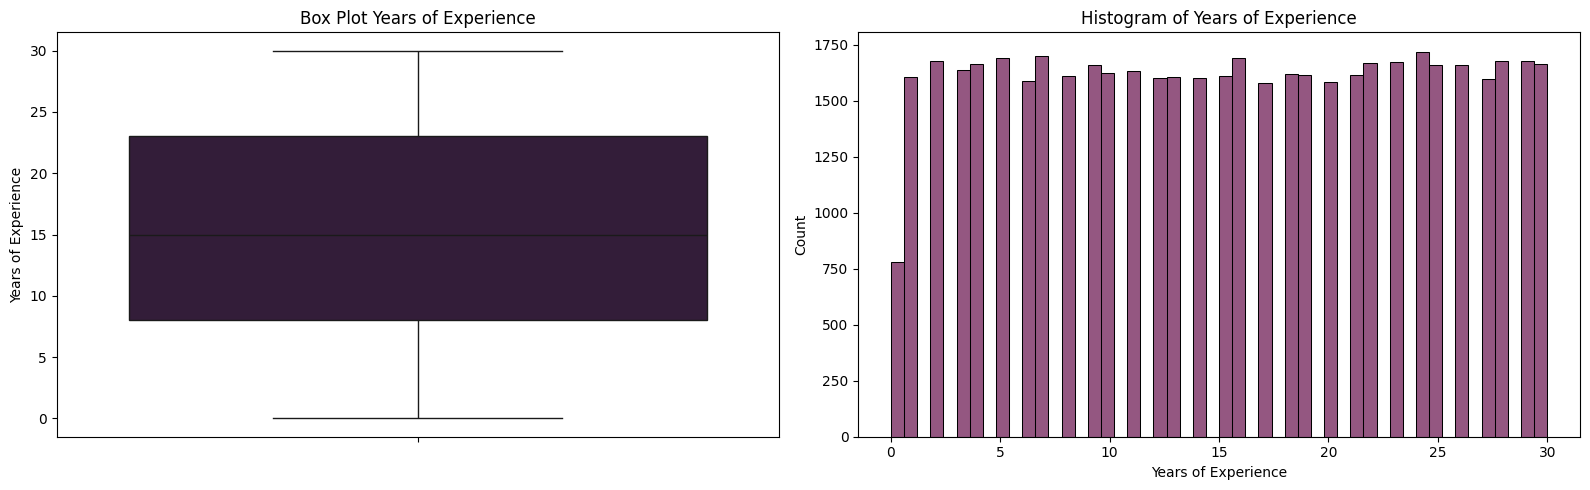

In [7]:
_, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(16, 5))

sns.boxplot(raw_candidates['yoe'], ax=ax1, color=colors[0])
ax1.set_ylabel("Years of Experience")
ax1.set_title("Box Plot Years of Experience")

sns.histplot(raw_candidates['yoe'], bins=50, ax=ax2, color=colors[1])
ax2.set_xlabel("Years of Experience")
ax2.set_title("Histogram of Years of Experience")

plt.tight_layout()
plt.show()

#### Binary Data

##### hired = code_challenge_score + technical_interview_score

We could interpretate both variables by separate which is the standard but our goal is to check by hired or not hired (which is the mix of these two) and that both are above 7 points, like we don't have nulls to handle in these columns we can straight up mix them to create the hired column.

From this one we can see that **86.6%** of application get hired vs the **13.4%** that were not, showing an imbalance in the column.

In [8]:
def is_hired(row) -> bool:
    return row['code_challenge_score'] >= 7 and row['technical_interview_score'] >= 7

In [9]:
raw_candidates['hired'] = raw_candidates.apply(is_hired, axis=1)
raw_candidates['hired']

0        False
1        False
2         True
3        False
4         True
         ...  
49995    False
49996    False
49997    False
49998    False
49999    False
Name: hired, Length: 50000, dtype: bool

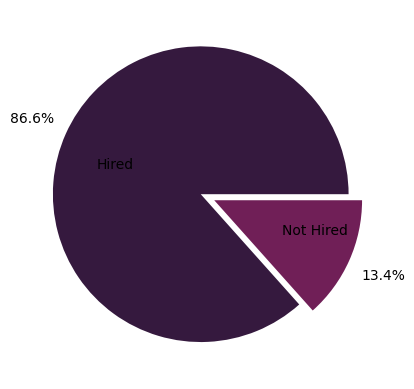

In [10]:
hired_counts = raw_candidates['hired'].value_counts()
labels = ['Hired', 'Not Hired']
explode = (0, 0.10)

colors_theme = colors[0:len(labels)]

_, ax = plt.subplots()
ax.pie(hired_counts, labels=labels, autopct='%1.1f%%',
       pctdistance=1.25, labeldistance=.5, explode=explode, colors=colors_theme)
plt.show()

#### Categorical Data

##### Application Date

The applications are captured from 2018 to 2022

In [11]:
raw_candidates['application_date_year'] = pd.to_datetime(raw_candidates['application_date']).dt.year
raw_candidates['application_date_month'] = pd.to_datetime(raw_candidates['application_date']).dt.month
application_counts = raw_candidates['application_date_year'].value_counts()
application_counts

application_date_year
2020    11237
2018    11061
2021    11051
2019    11009
2022     5642
Name: count, dtype: int64

In [12]:
years_with_min_applications, years_with_max_applications = get_min_max_counts(application_counts)

In [13]:
print(f"The year {start_bold}{years_with_min_applications}{end_bold} got ({start_bold}{application_counts[years_with_min_applications]}{end_bold}) the lower number of applications, while the {start_bold}{years_with_max_applications}{end_bold} got ({start_bold}{application_counts[years_with_max_applications]}{end_bold}) the year with most applications reported.")

The year 2022 got (5642) the lower number of applications, while the 2020 got (11237) the year with most applications reported.


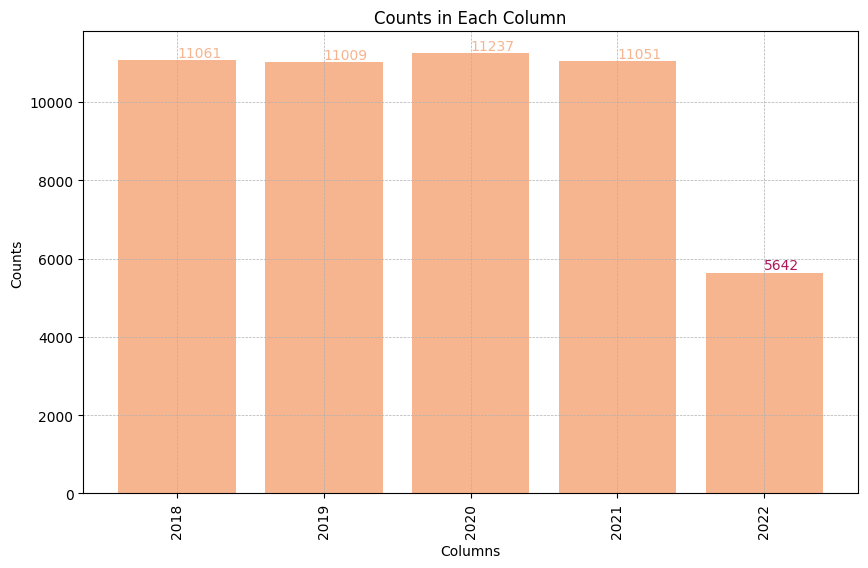

In [14]:
plot_counts(application_counts, 10000, 1000)

##### Email

The **~99.7%** are unique emails, meaning that a low number of people do more than one application.

In [15]:
percentage_dup_emails = (100 - (raw_candidates['email'].unique().shape[0] / raw_candidates.shape[0]) * 100)

In [16]:
print(f"There is a {start_bold}{percentage_dup_emails:.1f}%{end_bold} of users with the same email sending multiple applications.")

There is a 0.3% of users with the same email sending multiple applications.


In [17]:
emails = raw_candidates['email']
applications_by_dup_email = raw_candidates[emails.isin(emails[emails.duplicated()])].sort_values("email")
dup_emails = applications_by_dup_email['email'].value_counts().head(5).sort_values(ascending=False)

In [18]:
dup_emails_values = "\n".join([f"{start_bold}{email}{end_bold}: {count} applications" for email, count in dup_emails.items()])

In [19]:
print(f"""
From {start_bold}{raw_candidates.shape[0]}{end_bold} there are {start_bold}{raw_candidates['email'].unique().shape[0]}{end_bold} unique emails:

The top 5 with more applications are:

{dup_emails_values}

""")


From 50000 there are 49833 unique emails:

The top 5 with more applications are:

marianne31@yahoo.com: 3 applications
fern70@gmail.com: 3 applications
mariah80@hotmail.com: 2 applications
marguerite94@gmail.com: 2 applications
khalil.oconnell@yahoo.com: 2 applications




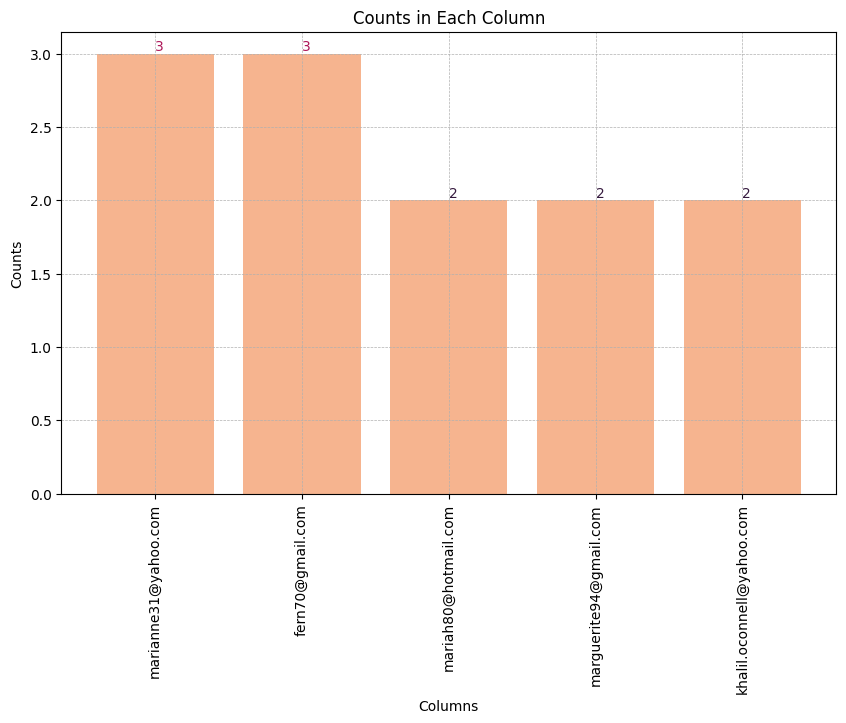

In [20]:
plot_counts(dup_emails, 3, 2)

##### Country

Let's take a look at the scores from the countries we're interested in!

In [21]:
TARGET_COUNTRIES = ['United States of America', 'Brazil', 'Colombia', 'Ecuador']

In [22]:
target_countries = raw_candidates[raw_candidates['country'].isin(TARGET_COUNTRIES)].copy()
target_countries_counts = target_countries['country'].value_counts().sort_values(ascending=False)

###### **USA, Brazil, Colombia, and Ecuador**

In [23]:
target_countries_names = "\n".join([f"{start_bold}{country}{end_bold}: {count} applications" for country, count in target_countries_counts.items()])

In [24]:
print(f"""
The are applications from these {start_bold}{target_countries_counts.shape[0]}{end_bold} countries.

The number of applications per country are the next:

{target_countries_names}
""")


The are applications from these 4 countries.

The number of applications per country are the next:

Colombia: 226 applications
Brazil: 204 applications
Ecuador: 203 applications
United States of America: 188 applications



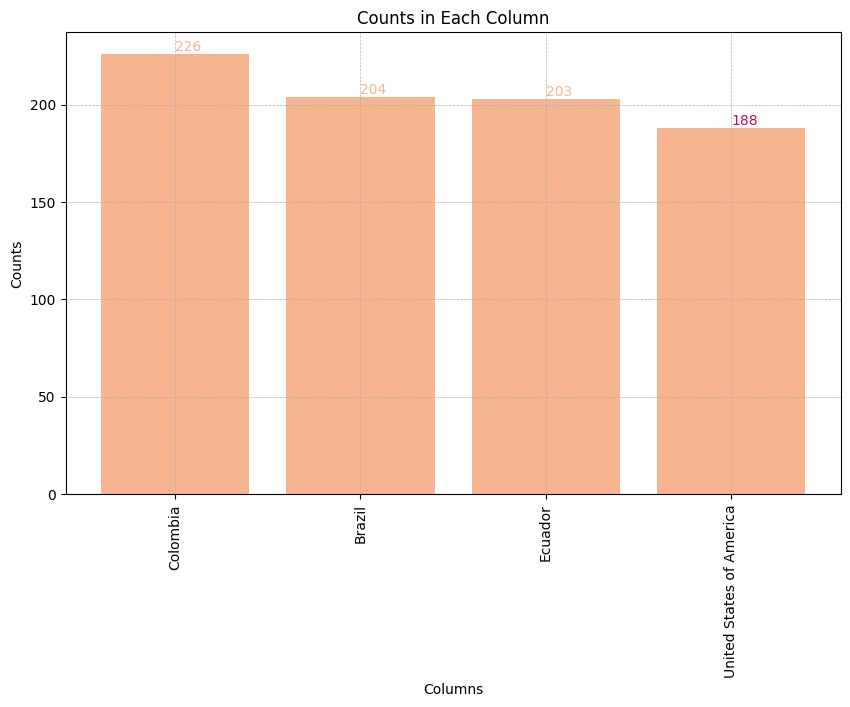

In [25]:
plot_counts(target_countries_counts, 200, 100)

###### **Top Ten**

Even thought the number of applications are high, our target countries **don't make it into the top ten** with most applications. **Colombia** being short of **5 applications to make it.**

In [26]:
top_ten = raw_candidates['country'].value_counts().head(10).sort_values(ascending=False)

top_ten_names = "\n".join([f"{start_bold}{country}{end_bold}: {count} applications" for country, count in top_ten.items()])

In [27]:
print(f"""
There are applications from {start_bold}{raw_candidates['country'].unique().shape[0]}{end_bold} countries.

The top ten countries with most application are:

{top_ten_names}
""")


There are applications from 244 countries.

The top ten countries with most application are:

Malawi: 242 applications
Spain: 238 applications
Netherlands Antilles: 234 applications
Svalbard & Jan Mayen Islands: 234 applications
Cook Islands: 234 applications
Tajikistan: 233 applications
Samoa: 232 applications
Italy: 232 applications
Malaysia: 232 applications
Taiwan: 231 applications



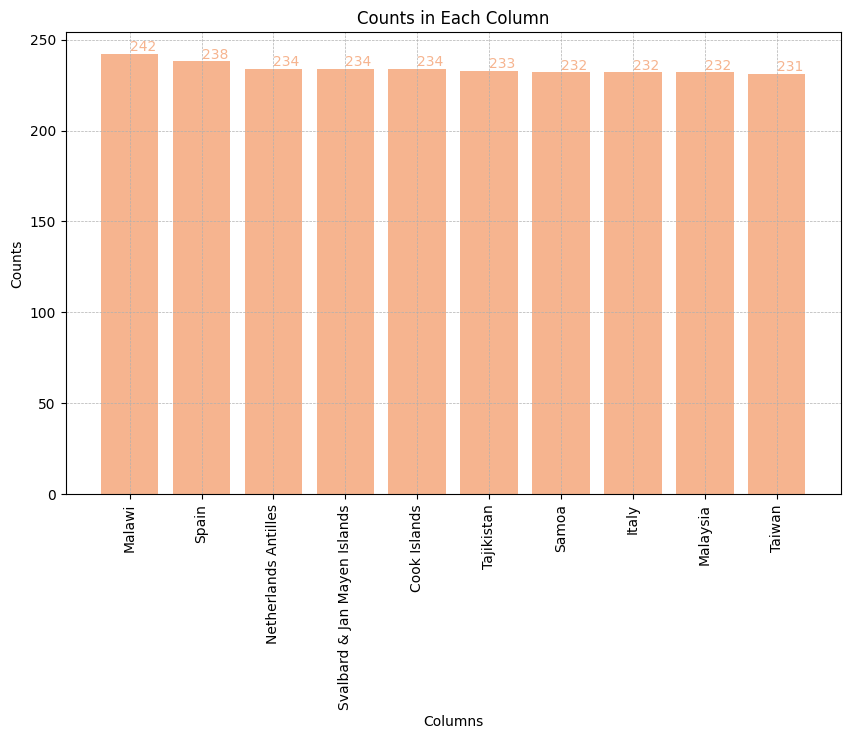

In [28]:
plot_counts(top_ten, 200, 100)

##### Seniority

The seniorities in our dataset seems to be balanced with the difference between the min and max number of application per seniority being around **200 applications**.

In [29]:
seniority_counts = raw_candidates['seniority'].value_counts().sort_values(ascending=False)
seniority_labels = "\n".join([f"{start_bold}{seniority}{end_bold}: {count} applications" for seniority, count in seniority_counts.items()])

In [30]:
seniority_with_min_applications, seniority_with_max_applications = get_min_max_counts(seniority_counts)

In [31]:
print(f"The seniority {start_bold}{seniority_with_min_applications}{end_bold} got ({start_bold}{seniority_counts[seniority_with_min_applications]}{end_bold}) the lower number of applications, while the {start_bold}{seniority_with_max_applications}{end_bold} got ({start_bold}{seniority_counts[seniority_with_max_applications]}{end_bold}) the seniority with most applications reported.")

The seniority Senior got (7059) the lower number of applications, while the Intern got (7255) the seniority with most applications reported.


In [32]:
print(f"""
The seniorities that have apply are the next: 
{seniority_labels}
""")


The seniorities that have apply are the next: 
Intern: 7255 applications
Mid-Level: 7253 applications
Trainee: 7183 applications
Junior: 7100 applications
Architect: 7079 applications
Lead: 7071 applications
Senior: 7059 applications



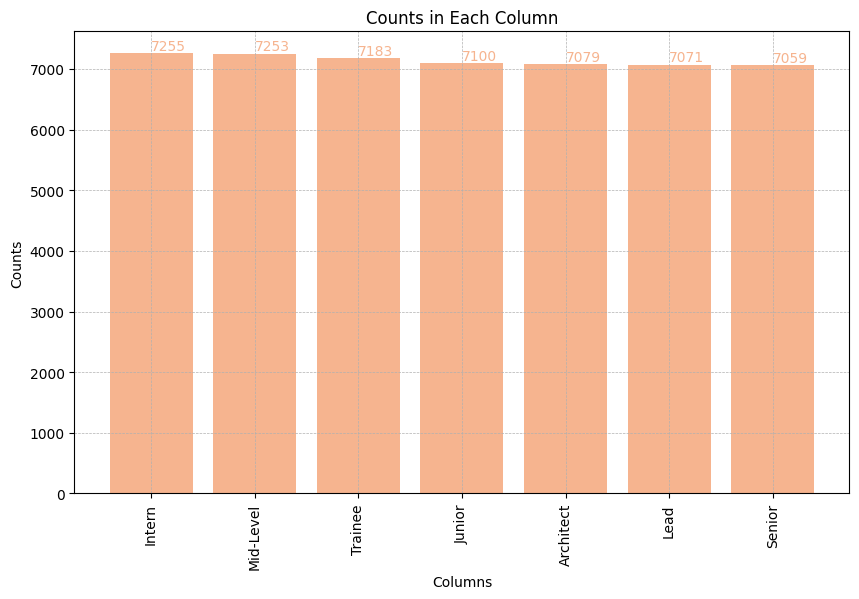

In [33]:
plot_counts(seniority_counts, 7000, 4000)

##### Technology

Due to the large number of categories and the application sparsed accross them we have created a parent category to group them and have more manageable technologies.
The technologies related to **Coding and Development** are leading the number of application while the **System Integration and Connectivity** are the ones with least demand.

In [34]:
technology_counts = raw_candidates['technology'].value_counts().sort_values(ascending=False)
technology_labels = "\n".join([f"{start_bold}{technology}{end_bold}: {count} applications" for technology, count in technology_counts.items()])

In [35]:
technology_with_min_applications, technology_with_max_applications = get_min_max_counts(technology_counts)

In [36]:
print(f"The seniority {start_bold}{technology_with_min_applications}{end_bold} got ({start_bold}{technology_counts[technology_with_min_applications]}{end_bold}) the lower number of applications, while the {start_bold}{technology_with_max_applications}{end_bold} got ({start_bold}{technology_counts[technology_with_max_applications]}{end_bold}) the seniority with most applications reported.")

The seniority Security Compliance got (1852) the lower number of applications, while the Game Development got (3818) the seniority with most applications reported.


In [37]:
print(f"""
From the {raw_candidates.shape[0]} applications we can found {raw_candidates['technology'].unique().shape[0]} different technologies

The seniorities that have apply are the next: 
{technology_labels}
""")


From the 50000 applications we can found 24 different technologies

The seniorities that have apply are the next: 
Game Development: 3818 applications
DevOps: 3808 applications
Social Media Community Management: 2028 applications
System Administration: 2014 applications
Mulesoft: 1973 applications
Development - Backend: 1965 applications
Development - FullStack: 1961 applications
Adobe Experience Manager: 1954 applications
Data Engineer: 1951 applications
Security: 1936 applications
Development - CMS Frontend: 1934 applications
Business Intelligence: 1934 applications
Database Administration: 1933 applications
Client Success: 1927 applications
Design: 1906 applications
QA Manual: 1902 applications
Technical Writing: 1901 applications
QA Automation: 1892 applications
Sales: 1890 applications
Development - Frontend: 1887 applications
Development - CMS Backend: 1882 applications
Business Analytics / Project Management: 1878 applications
Salesforce: 1874 applications
Security Compliance: 

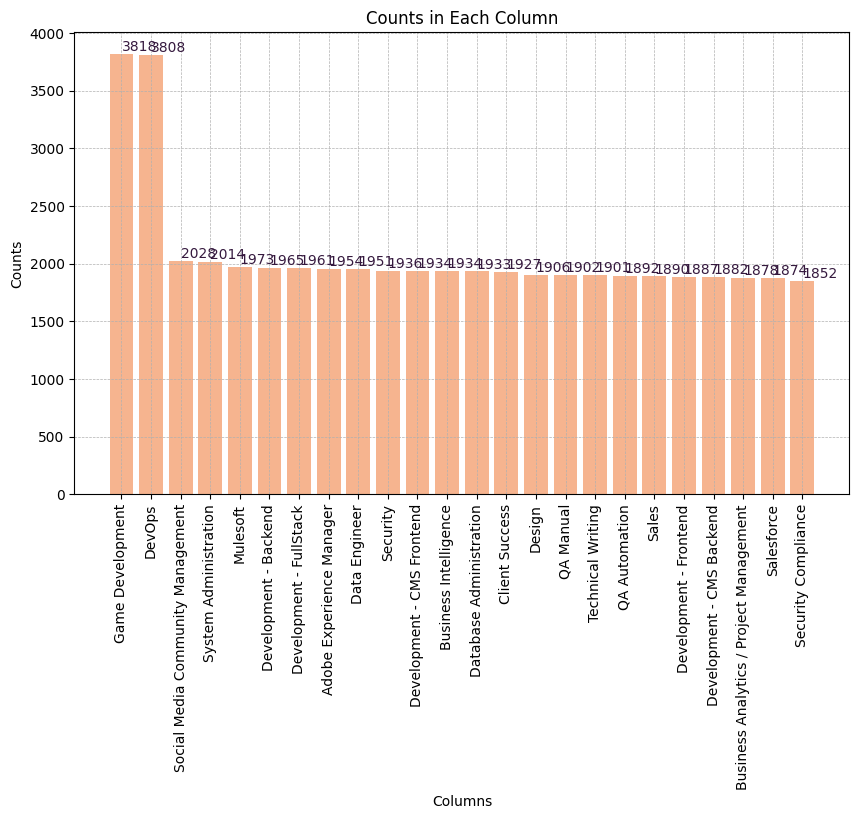

In [38]:
plot_counts(technology_counts, 7000, 4000)

In [39]:
technology_categories_map = {
    'Development': 'Coding and Development',
    'Game': 'Coding and Development',
    'Business': 'Data Science and Analysis',
    'Data': 'Data Science and Analysis',
    'Database': 'System Infrastructure and Management',
    'System': 'System Infrastructure and Management',
    'DevOps': 'System Infrastructure and Management',
    'QA': 'Testing and Quality Management',
    'Security': 'Cybersecurity and Protection',
    'Client': 'Client Engagement and Success',
    'Sales': 'Client Engagement and Success',
    'Social Media': 'Client Engagement and Success',
    'Technical': 'Creative Content and Design',
    'Design': 'Creative Content and Design',
    'Adobe': 'Creative Content and Design',
    'Mulesoft': 'System Integration and Connectivity'
}

In [40]:
def categorize_technology(row, categories_dict):
    technology_title = row['technology']
    for key in categories_dict:
        if key in technology_title:
            return categories_dict[key]
    return 'Other'

In [41]:
target_countries.head()

,first_name,last_name,email,application_date,country,yoe,seniority,technology,code_challenge_score,technical_interview_score,hired,application_date_year,application_date_month
59,Darian,Kris,jack62@gmail.com,2021-01-01,United States of America,4,Mid-Level,Salesforce,9,4,False,2021,1
75,Tabitha,Simonis,ella.mcclure57@hotmail.com,2021-07-21,Ecuador,15,Senior,Development - Backend,0,1,False,2021,7
84,Harvey,Hackett,anibal_gorczany63@gmail.com,2020-10-18,Brazil,18,Senior,DevOps,1,8,False,2020,10
108,Kennith,Dickens,letha.botsford51@gmail.com,2020-06-11,Ecuador,5,Mid-Level,Data Engineer,4,1,False,2020,6
201,Mittie,Rohan,cathryn36@yahoo.com,2021-05-30,Brazil,8,Mid-Level,Adobe Experience Manager,3,2,False,2021,5


In [42]:
raw_candidates['technology_category'] = raw_candidates.apply(categorize_technology, categories_dict=technology_categories_map, axis=1)
applications_by_dup_email['technology_category'] = applications_by_dup_email.apply(categorize_technology, categories_dict=technology_categories_map, axis=1)
target_countries['technology_category'] = target_countries.apply(categorize_technology, categories_dict=technology_categories_map, axis=1)

In [43]:
technology_category_counts = raw_candidates['technology_category'].value_counts()

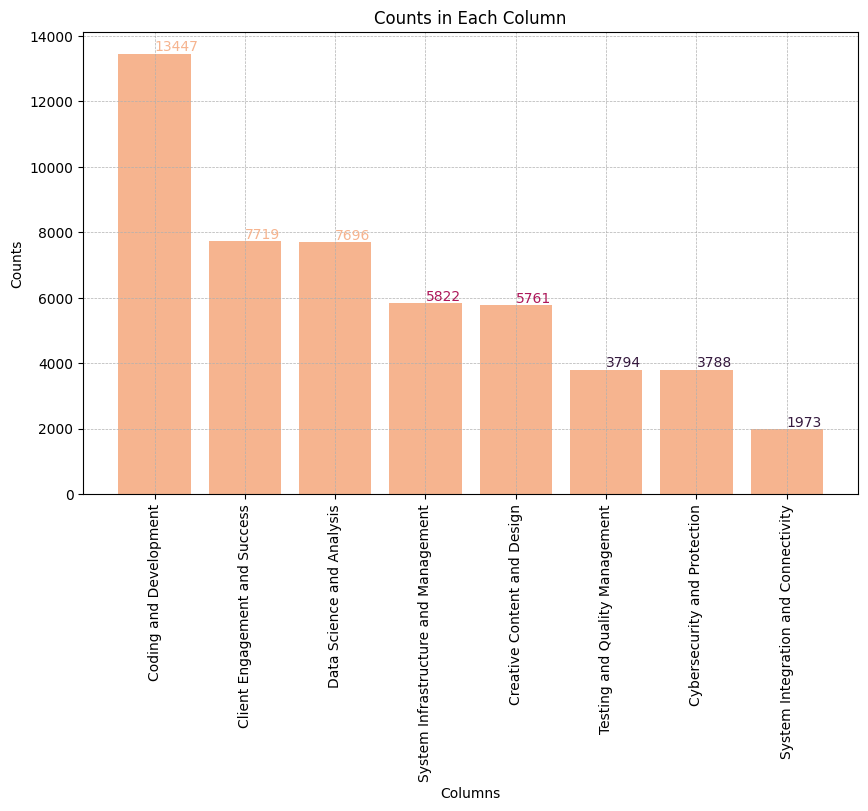

In [44]:
plot_counts(technology_category_counts, 7000, 4000)

In [45]:
technology_with_min_applications, technology_with_max_applications = get_min_max_counts(technology_category_counts)

In [46]:
print(f"The seniority {start_bold}{technology_with_min_applications}{end_bold} got ({start_bold}{technology_category_counts[technology_with_min_applications]}{end_bold}) the lower number of applications, while the {start_bold}{technology_with_max_applications}{end_bold} got ({start_bold}{technology_category_counts[technology_with_max_applications]}{end_bold}) the seniority with most applications reported.")

The seniority System Integration and Connectivity got (1973) the lower number of applications, while the Coding and Development got (13447) the seniority with most applications reported.


### Bivariate and Multivariate Exploring

In the process of evaluating our single attributes some questions were raised that we could try to answer using two or more variables.


#### Were the multiple applications from duplicate emails submitted within the same year or across different years?

In [47]:
contingency_table = pd.crosstab(index=applications_by_dup_email['email'], 
                                columns=applications_by_dup_email['application_date_year'])

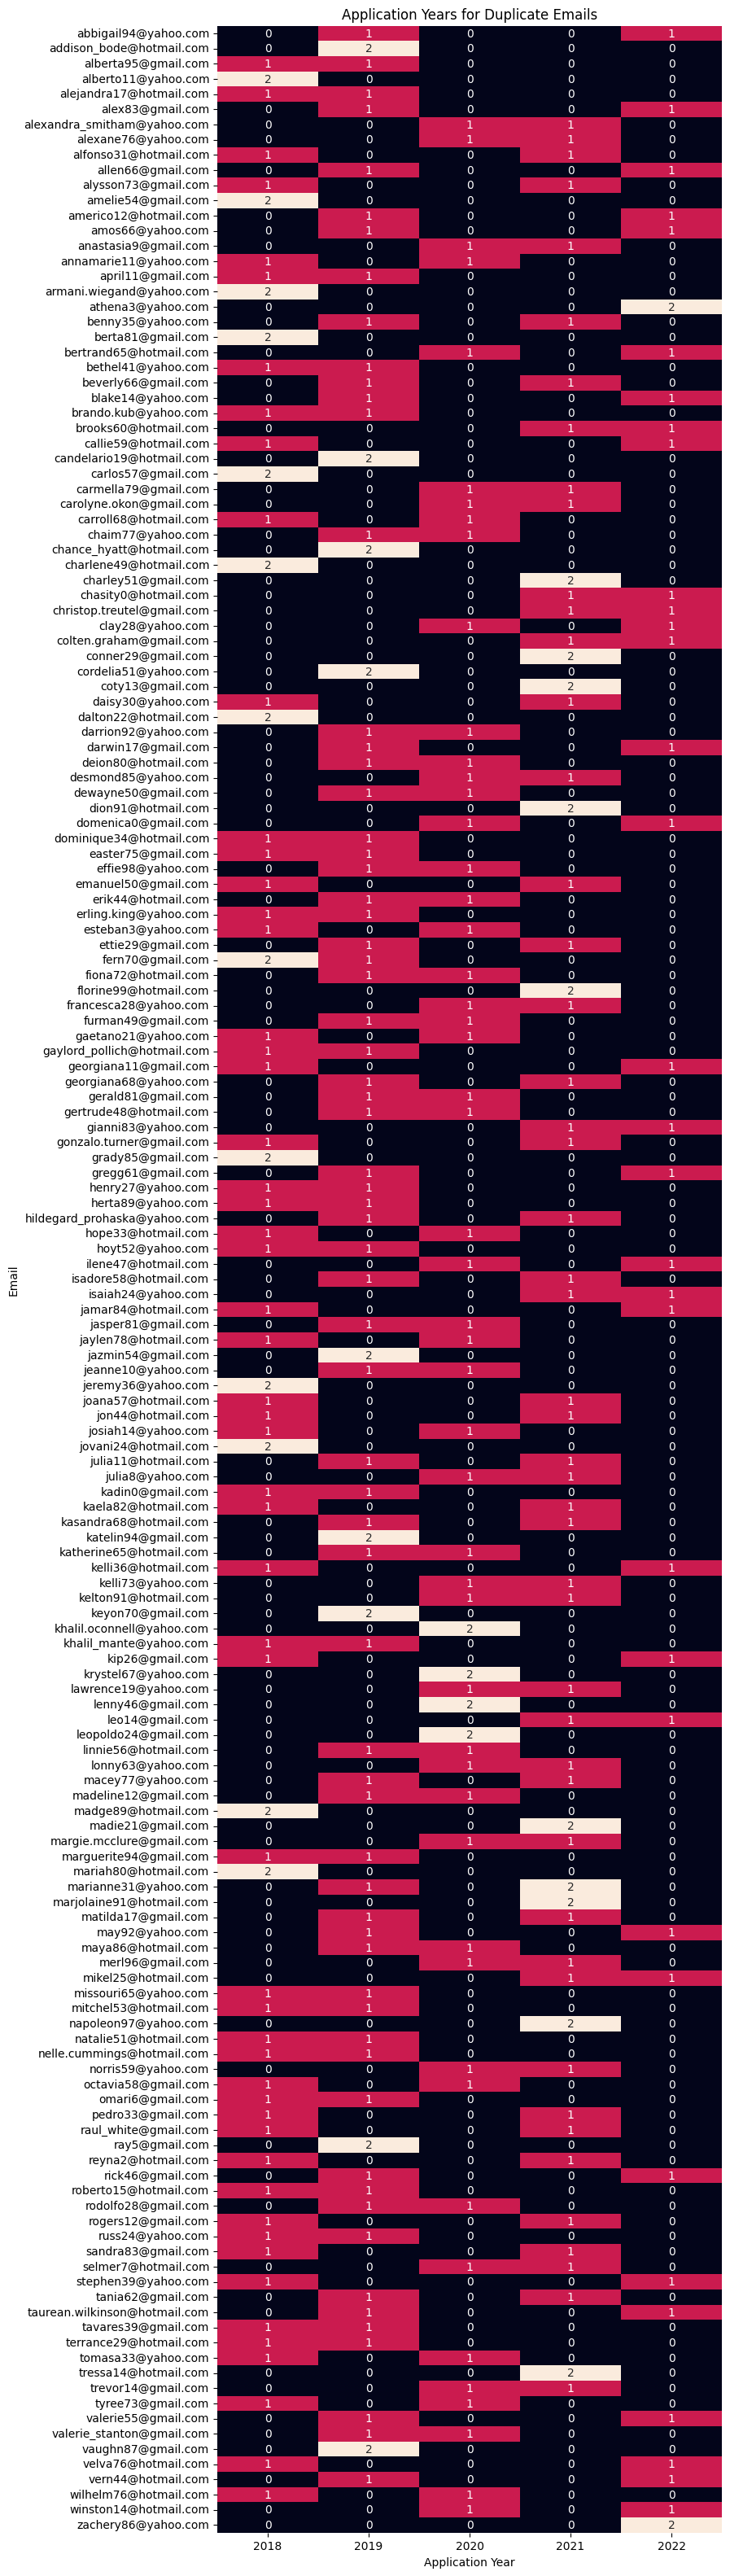

In [48]:
plt.figure(figsize=(8, 40))
sns.heatmap(contingency_table, fmt="g", cmap="rocket", annot=True, cbar=False)

plt.title('Application Years for Duplicate Emails')
plt.xlabel('Application Year')
plt.ylabel('Email')
plt.show()

#### Were the multiple applications from duplicate emails for the same technology?

In [49]:
contingency_table = pd.crosstab(index=applications_by_dup_email['email'], 
                                columns=applications_by_dup_email['technology_category'])

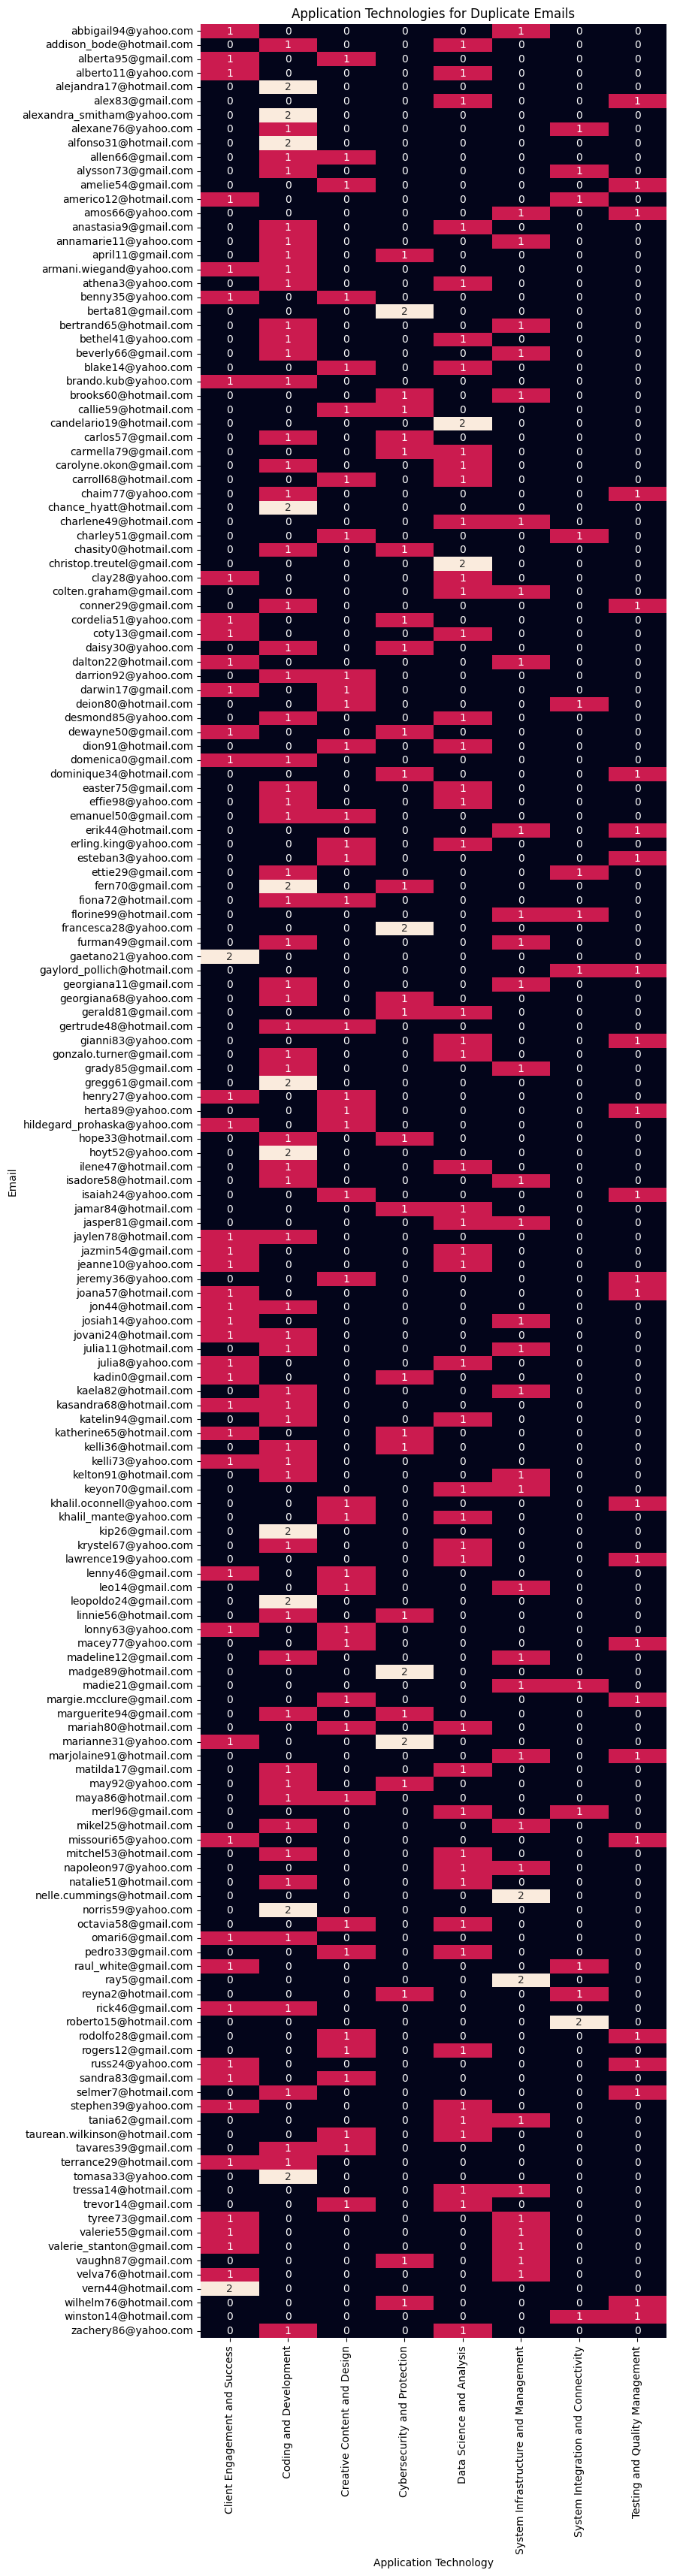

In [50]:
plt.figure(figsize=(8, 40))
sns.heatmap(contingency_table, fmt="g", cmap="rocket", annot=True, cbar=False)

plt.title('Application Technologies for Duplicate Emails')
plt.xlabel('Application Technology')
plt.ylabel('Email')
plt.show()

#### How is the distribution of years of experience across different seniority levels?

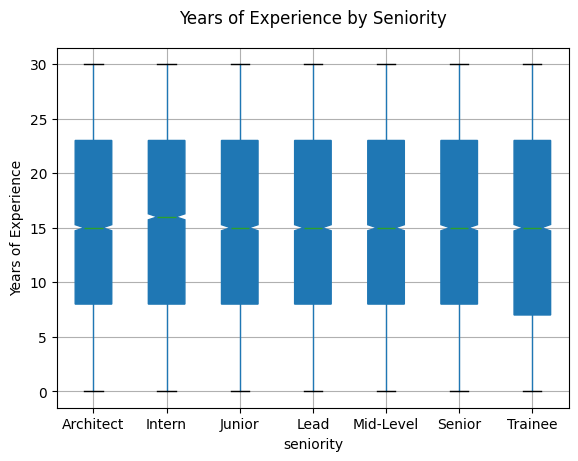

In [51]:
ax = raw_candidates.boxplot(by='seniority', column='yoe', notch=True, patch_artist=True)
ax.set_ylabel('Years of Experience')
plt.title('')
plt.suptitle("Years of Experience by Seniority")
plt.show()

#### Which technologies are most applied for by country?

In [52]:
contingency_table = pd.crosstab(index=target_countries['technology_category'], 
                                columns=target_countries['country'])

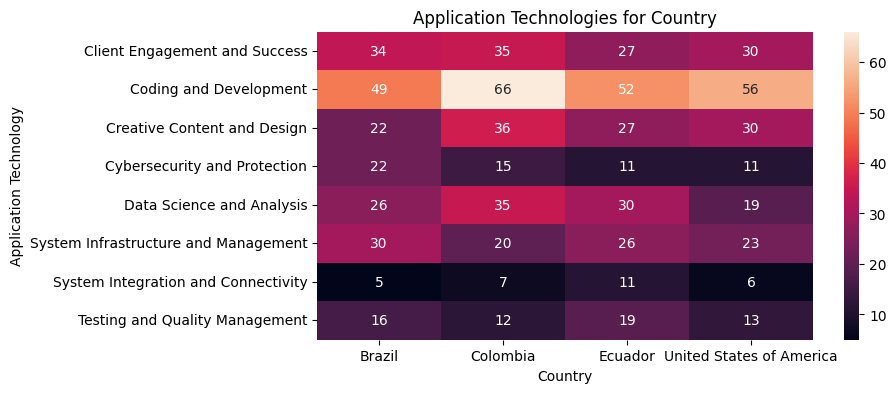

In [53]:
plt.figure(figsize=(8, 4))
sns.heatmap(contingency_table, fmt="g", cmap="rocket", annot=True)

plt.title('Application Technologies for Country')
plt.xlabel('Country')
plt.ylabel('Application Technology')
plt.show()

#### How many individuals have been hired, categorized by seniority level?

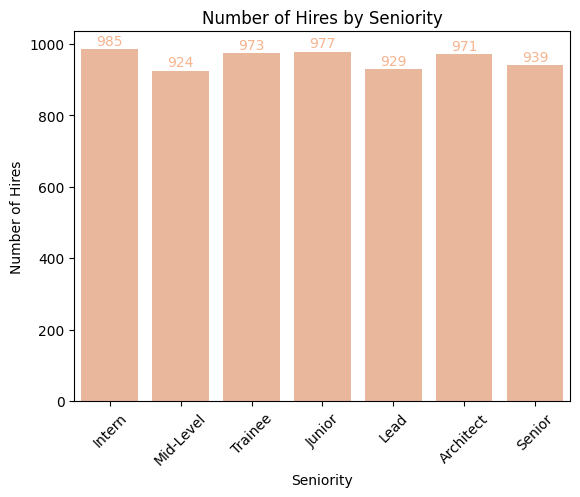

In [54]:
raw_candidates['hired'] = raw_candidates['hired'].astype(int)

ax = sns.barplot(x='seniority', y='hired', data=raw_candidates, estimator=sum, errorbar=None, color=colors[len(colors)-1])

plt.ylabel('Number of Hires')
plt.xlabel('Seniority')
plt.title('Number of Hires by Seniority')
plt.xticks(rotation=45)

for p in ax.patches:
    yval = int(p.get_height())
    color = get_color(yval, 800, 300)
    ax.annotate(f'{yval}',
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center',
                xytext=(0, 6),
                textcoords='offset points',
                color=color)


plt.show()

#### How many individuals have been hired, categorized by technology?

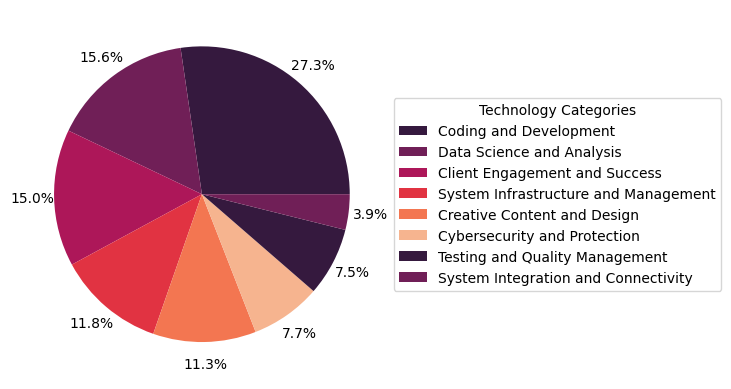

In [55]:
technology_counts = raw_candidates[raw_candidates['hired'] == 1]['technology_category'].value_counts()
labels = technology_counts.index

colors_theme = colors[0:len(labels)]

_, ax = plt.subplots()
wedges, _, _ = ax.pie(technology_counts, autopct='%1.1f%%',
                                  pctdistance=1.15, colors=colors_theme)

plt.legend(wedges, labels, title="Technology Categories", loc="center left", bbox_to_anchor=(1, 0, 0, 1))

plt.show()

#### How many individuals have been hired, categorized by country?

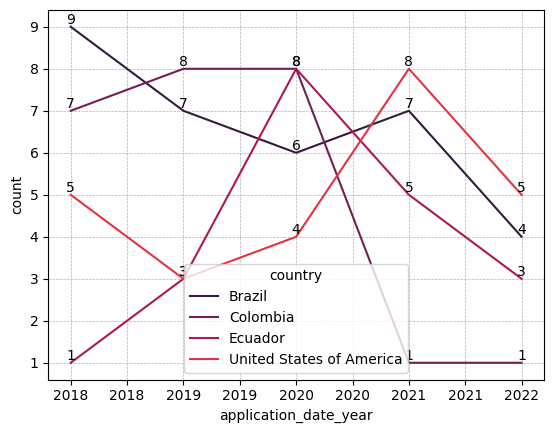

In [56]:
filtered_countries = target_countries[target_countries['hired'] == 1]
country_time_counts = filtered_countries.groupby(['country', 'application_date_year'])['hired'].count().reset_index(name='count')

sns.lineplot(x='application_date_year', y='count', hue='country', data=country_time_counts, palette=[colors[i] for i in range(target_countries_counts.shape[0])])
plt.gca().xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: int(x)))
plt.grid(which='both', linestyle='--', linewidth=0.5, zorder=0)

for i, row in country_time_counts.iterrows():
    plt.text(row['application_date_year'], row['count'], str(row['count']), color='black', ha="center", va="bottom", zorder=4)

plt.show()

#### Which years had the highest number of hires?

In [57]:
hired_candidates_by_year = raw_candidates[raw_candidates['hired'] == 1]['application_date_year'].value_counts().sort_index()
hired_candidates_by_year

application_date_year
2018    1409
2019    1524
2020    1485
2021    1485
2022     795
Name: count, dtype: int64

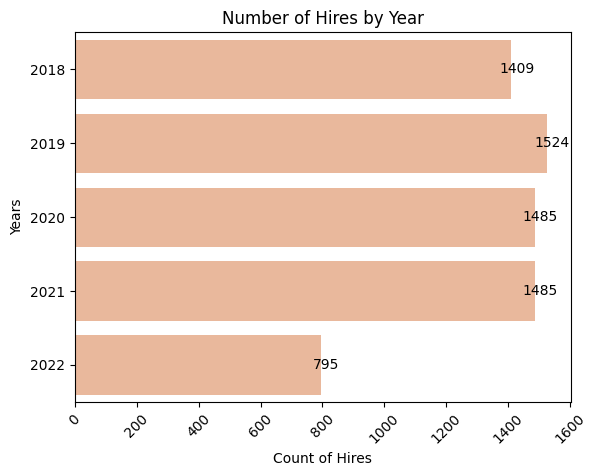

In [58]:
ax = sns.barplot(x=hired_candidates_by_year.values, y=hired_candidates_by_year.index, estimator=sum, errorbar=None, color=colors[len(colors)-1], orient='h')
plt.xlabel('Count of Hires')
plt.ylabel('Years')
plt.title('Number of Hires by Year')
plt.xticks(rotation=45)

for p in ax.patches:
    width = p.get_width()
    ax.annotate(f'{int(width)}', 
                (p.get_x() + width, p.get_y() + p.get_height() / 2), 
                ha='center', va='center', 
                xytext=(4, 0),
                textcoords='offset points')

### Store Data

In [59]:
FINAL_COLUMNS = [
    'email',
    'country',
    'yoe',
    'seniority',
    'technology',
    'hired',
    'application_date_year',
    'application_date_month',
    'technology_category',
]

In [60]:
clean_candidates = raw_candidates[FINAL_COLUMNS].copy()
clean_candidates.head()

,email,country,yoe,seniority,technology,hired,application_date_year,application_date_month,technology_category
0,leonard91@yahoo.com,Norway,2,Intern,Data Engineer,0,2021,2,Data Science and Analysis
1,zelda56@hotmail.com,Panama,10,Intern,Data Engineer,0,2021,9,Data Science and Analysis
2,okey_schultz41@gmail.com,Belarus,4,Mid-Level,Client Success,1,2020,4,Client Engagement and Success
3,elvera_kulas@yahoo.com,Eritrea,25,Trainee,QA Manual,0,2020,10,Testing and Quality Management
4,minnie.gislason@gmail.com,Myanmar,13,Mid-Level,Social Media Community Management,1,2020,5,Client Engagement and Success


In [61]:
clean_candidates.to_sql(settings.CLEAN_TABLE, engine, if_exists='replace', index=False)

1000

In [62]:
clean_candidates  = pd.read_sql_table(
    settings.CLEAN_TABLE,
    con=engine,
    columns=FINAL_COLUMNS,
)

In [63]:
clean_candidates.head()

,email,country,yoe,seniority,technology,hired,application_date_year,application_date_month,technology_category
0,leonard91@yahoo.com,Norway,2,Intern,Data Engineer,0,2021,2,Data Science and Analysis
1,zelda56@hotmail.com,Panama,10,Intern,Data Engineer,0,2021,9,Data Science and Analysis
2,okey_schultz41@gmail.com,Belarus,4,Mid-Level,Client Success,1,2020,4,Client Engagement and Success
3,elvera_kulas@yahoo.com,Eritrea,25,Trainee,QA Manual,0,2020,10,Testing and Quality Management
4,minnie.gislason@gmail.com,Myanmar,13,Mid-Level,Social Media Community Management,1,2020,5,Client Engagement and Success


### Final Thoughts

* Most of the data here is normalized, with no empty values and nulls.
* Even though we had emails duplicated, this never meant that the rows were duplicated, those were applications done on either different years or different technologies.
* We can see out of the gate that is random simulated data due that the in years of experience it follows the almost the same distribution for all seniorities, which does not make sense.